# Fine-tune pre-trained `twitter-xlm-roberta-base` transformer model on Hindi dataset

## Installs

Installation of **[transformers](https://github.com/huggingface/transformers)** and **[ml_things](https://github.com/gmihaila/ml_things)**.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00


In [4]:
!pip install odfpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 KB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160691 sha256=19b709a8d195dd8d7da0288c72d32283e86052f6ae4248377dbf6954052da0b3
  Stored in directory: /root/.cache/pip/wheels/20/ff/69/1b3f423ffe400b87afa368c70b43d2b5cd3bfb9ac8a613ba5b
Successfully built odfpy


Install matplotlib 3.1.3

In [2]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.7.1-py3.9-nspkg.pth
    /usr/local/lib/python3.9/dist-packages/matplotlib-3.7.1.dist-info/*
    /usr/local/lib/python3.9/dist-packages/matplotlib/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.9/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.9/dist-packages/pylab.py
Proceed (Y/n)? y
y
  Successfully uninstalled matplotlib-3.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp39-cp39-linux_x86_64.whl size=12062387 sha256=565966a6d06917e9daf3af8645fae6972a645ed164effce9beb9dfdcf

## Imports

Import necessary libraries



In [5]:
import io
import os
import torch
import urllib
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig, 
                          AutoModelForSequenceClassification, 
                          AutoTokenizer, AdamW, 
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

## Declaration of parameters


Declare parameters used in this notebook

In [6]:
# Set seed for reproducibility
set_seed(123)

# Number of training epochs 
epochs = 8

# Number of batch_size - depending on the max sequence length and avaialable GPU memory
# For 512 sequence length batch of 10 works without cuda memory issues
# For small sequence length one can try batch of 32 or higher
batch_size = 16

# Padd or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model
max_length = 550


# Look for gpu to use. Will use `cpu` by default if no gpu found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of the transformers model - will use already pretrained model
# Path of transformer model - will load your own model from local disk

#model_name_or_path = "monsoon-nlp/hindi-bert"
model_name_or_path = "monsoon-nlp/hindi-bert"

# Dicitonary of labels and their id - this will be used to convert string labels to number.
labels_ids = {'Control': 0, 'Dementia': 1}

# How many labels are we using in training
# This is used to decide size of classification head
n_labels = len(labels_ids)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the Hindi review dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the review dataset

In [8]:
import csv
x = []

with open("/content/drive/MyDrive/Hindi AD/new_Manual_dataset.csv", 'r') as file:
  csvreader = csv.reader(file)
  i = 0
  for row in csvreader:
    x.append(row)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df = pd.DataFrame(x)
header_row = df.iloc[0]
df = pd.DataFrame(df.values[1:], columns=header_row)
# print(df)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,google_translated_text,mbart50_m2m,m2m_100_1.2B,opus-mt,Result,Labels,manual_trans
543,well the little kid's falling off his stool . ...,खैर छोटा बच्चा अपने स्टूल से गिर रहा है। और मा...,"ठीक है, छोटा बच्चा अपनी कुर्सी से गिर रहा है। ...",छोटा बच्चा अपने कुर्सी से गिर रहा है। माँ के प...,छोटा बच्चा अपनी चौकी से गिर रहा है. और वह (बस्...,Dementia,1,अच्छ छोटा बच्चा अपने मल से गिर रहा है। और माँ ...
544,mhm . well this one is in the cookie jar . and...,एमएचएम। खैर यह एक कुकी जार में है। और उसने चढ़...,mhm। यह एक कुकी के बर्तन में है। और वो चढ़ने क...,एमएम यह एक कुकी जार में है। और वह चढ़ने की कोश...,mh. अच्छी तरह से इस आदमी कुकी जार में है. और व...,Dementia,1,महम। अच्छा यह कुकी जार में है। और उसने चढ़ने क...
545,hm the little boy is on the stool which is ti...,एचएम छोटा लड़का स्टूल पर है जो टिपिंग कर रहा ह...,"हां, छोटा लड़का स्टूल पर है जो झुक रहा है और व...","हाँ, छोटा लड़का कुर्सी पर है जो टिपिंग कर रहा ...",छोटे लड़के को उस चौकी पर है जिस पर सरकना है और...,Dementia,1,हम्म छोटा लड़का स्टूल पर है जो ढो रहा है और वह...
546,oh you want me to tell you . the mother and he...,"ओह, आप चाहते हैं कि मैं आपको बताऊं। माँ और उसक...",ओह तुम चाहते हो कि मैं तुम्हें बता दूँ। मां और...,आप चाहते हैं कि मैं आपको बताऊं। मां और उसके दो...,ओह तुम मुझे तुम्हें बताने के लिए चाहते हैं. मा...,Dementia,1,"ओह, आप चाहते हैं कि मैं आपको बता दूं। माँ और उ..."
547,oh that kid's gonna get a good spill off of th...,"ओह, कि बच्चे को उस स्टूल से एक अच्छा फैल जाना ...",ओह उस बच्चे को उस स्टूल से अच्छी तरह से बाहर न...,"ओह, उस बच्चे को उस मल से अच्छी तरह से फेंक दिय...",ओह है कि बच्चे वहाँ के चारों ओर नहीं बारी है क...,Dementia,1,अगर उसकी माँ वहाँ नहीं घूमी और उसे पकड़ नहीं ल...


In [11]:
len(df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


548

In [12]:
df['opus-mt'] = df[['opus-mt']].apply(lambda x: x.str.strip()).replace('', np.nan)
df = df.dropna(subset=['opus-mt'])
df.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
len(df)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


548

In [14]:
df = df[['Labels', 'opus-mt']]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
df['Labels'] = df['Labels'].astype(int)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-15-3bfde37d1095>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Labels'] = df['Labels'].astype(int)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


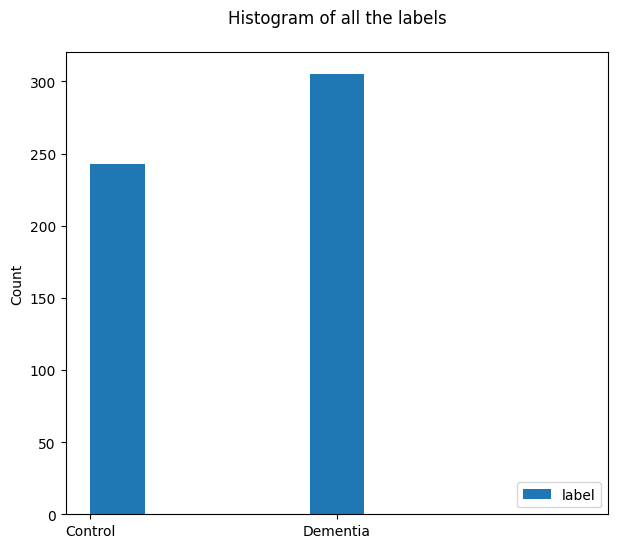

In [16]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of all the labels\n')
plt.hist([df["Labels"]], bins, label=['label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

Save the data as csv

Split the data into train, test and validation sets

In [48]:
train, val, test = np.split(df.sample(frac=1), [int(.89*len(df)), int(.93*len(df))])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
print ("Size of training dataset-->", len(train))
print ("Size of test dataset-->", len(test))
print ("Size of validation dataset-->", len(val))

Size of training dataset--> 487
Size of test dataset--> 39
Size of validation dataset--> 22


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Extract training, testing and validation texts and labels

In [50]:
train_text = list(train ['opus-mt'])
train_labels = list(train ['Labels'])

test_text = list(test ['opus-mt'])
test_labels = list(test ['Labels'])

val_text = list(val ['opus-mt'])
val_labels = list(val ['Labels'])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plot a historgram with the distribution of training labels

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


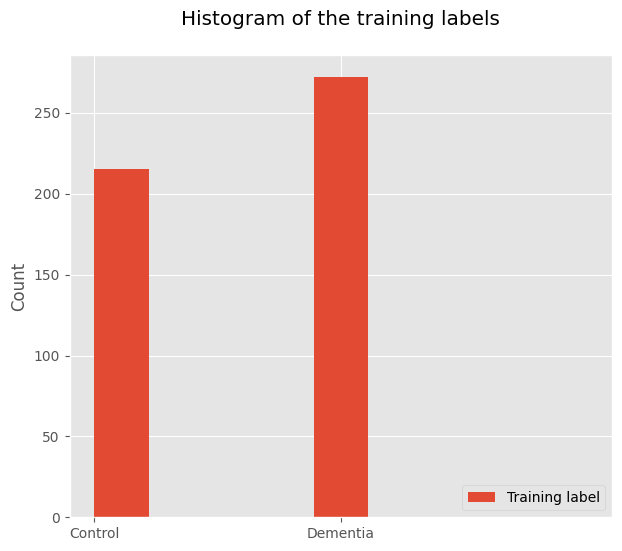

In [51]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots(figsize=(7, 6))
plt.title('Histogram of the training labels\n')
plt.hist([train_labels], bins, label=['Training label'] )
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(list(labels_ids.keys()))
ax.legend(loc='lower right')
plt.show()

In [52]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch
  total_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data we run the loop
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch)
    # This will return the loss (rather than the model output) because we have provided the `labels`.
    # The documentation for a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
    # We will use logits later to calculate training accuracy.
    #loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

    # Alternatively, you can just get the logits and calculate the loss yourself as follows
    labels = batch.pop("labels")
    loss = F.cross_entropy(outputs.logits, labels)
    logits = outputs.logits


    # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
    # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch
  total_loss = 0

  # Put the model in evaluation mode (the dropout layers behave differently during evaluation)
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # Move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
        # `token_type_ids` is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple along with the logits. 
        # We will use logits later to to calculate training accuracy.
        # loss, logits = outputs[:2] # UNCOMMENT THIS IF YOU DON'T WANT TO CALCULATE THE LOSS YOURSELF

        # Alternatively, you can just get the logits and calculate the loss yourself as follows
        labels = batch.pop("labels")
        loss = F.cross_entropy(outputs.logits, labels)
        logits = outputs.logits
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# Get model configuration
print('Loading model configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                          num_labels=n_labels)

# Get model's tokenizer
print('Loading model tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model
print('Loading the model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, 
                                                           config=model_config)

# Load model to the defined device
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading model configuraiton...
Loading model tokenizer...


Some weights of the model checkpoint at monsoon-nlp/hindi-bert were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-bert and are newly initialized: ['classifier.out_proj.bias', 'classi

Loading the model...
Model loaded to `cuda`


## Data encoding and create DataLoader object

Create data encodings

In [56]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(val_text, truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=max_length)

train_dataset = MyDataset(train_encodings, train_labels)
valid_dataset = MyDataset(valid_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Create DataLoader objects that will be fed into our model

In [57]:
train_dataloader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)
print('Created `test_dataloader` with %d batches!'%len(test_dataloader))

valid_dataloader = DataLoader (valid_dataset, batch_size=batch_size, shuffle=False)
print('Created `valid_dataloader` with %d batches!'%len(valid_dataloader))

Created `train_dataloader` with 31 batches!
Created `test_dataloader` with 3 batches!
Created `valid_dataloader` with 2 batches!


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Train the model

**Steps:**

1. Create optimizer and scheduler used by PyTorch in training

2. Loop through the number of defined epochs and call the **train** and **validation** functions

3. Store the outputs, which are similar info after each epoch as in Keras: *train_loss,   val_loss,   train_acc, valid_acc*

4. After training, plot train and validation loss and accuracy curves to check how the training went

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
optimizer = AdamW (model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  no_deprecation_warning=True
                  )

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batched data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup (optimizer, 
                                            num_warmup_steps = 10, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


# Loop through each epoch
print('Epoch')
for epoch in tqdm (range(epochs)):
  print()

  print('Training on batches...')
  # Perform one full pass over the training set
  train_labels, train_predict, train_loss = train (train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score (train_labels, train_predict)

  # Get prediction from model on validation data
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation (valid_dataloader, device)
  val_acc = accuracy_score (valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss values for plotting the learning curve
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)

  # Store the accuracy values
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/8 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.69039 - val_loss: 0.70768 - train_acc: 0.54415 - valid_acc: 0.50000


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.68703 - val_loss: 0.71591 - train_acc: 0.55852 - valid_acc: 0.50000


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.68523 - val_loss: 0.71445 - train_acc: 0.56057 - valid_acc: 0.50000


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.68473 - val_loss: 0.69701 - train_acc: 0.56879 - valid_acc: 0.54545


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.68030 - val_loss: 0.72588 - train_acc: 0.57290 - valid_acc: 0.45455


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.65615 - val_loss: 0.66796 - train_acc: 0.65708 - valid_acc: 0.63636


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.62648 - val_loss: 0.65751 - train_acc: 0.75565 - valid_acc: 0.63636


Training on batches...


  0%|          | 0/31 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/2 [00:00<?, ?it/s]

  train_loss: 0.61933 - val_loss: 0.65874 - train_acc: 0.73922 - valid_acc: 0.63636



Plot the loss and accuracy curves

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


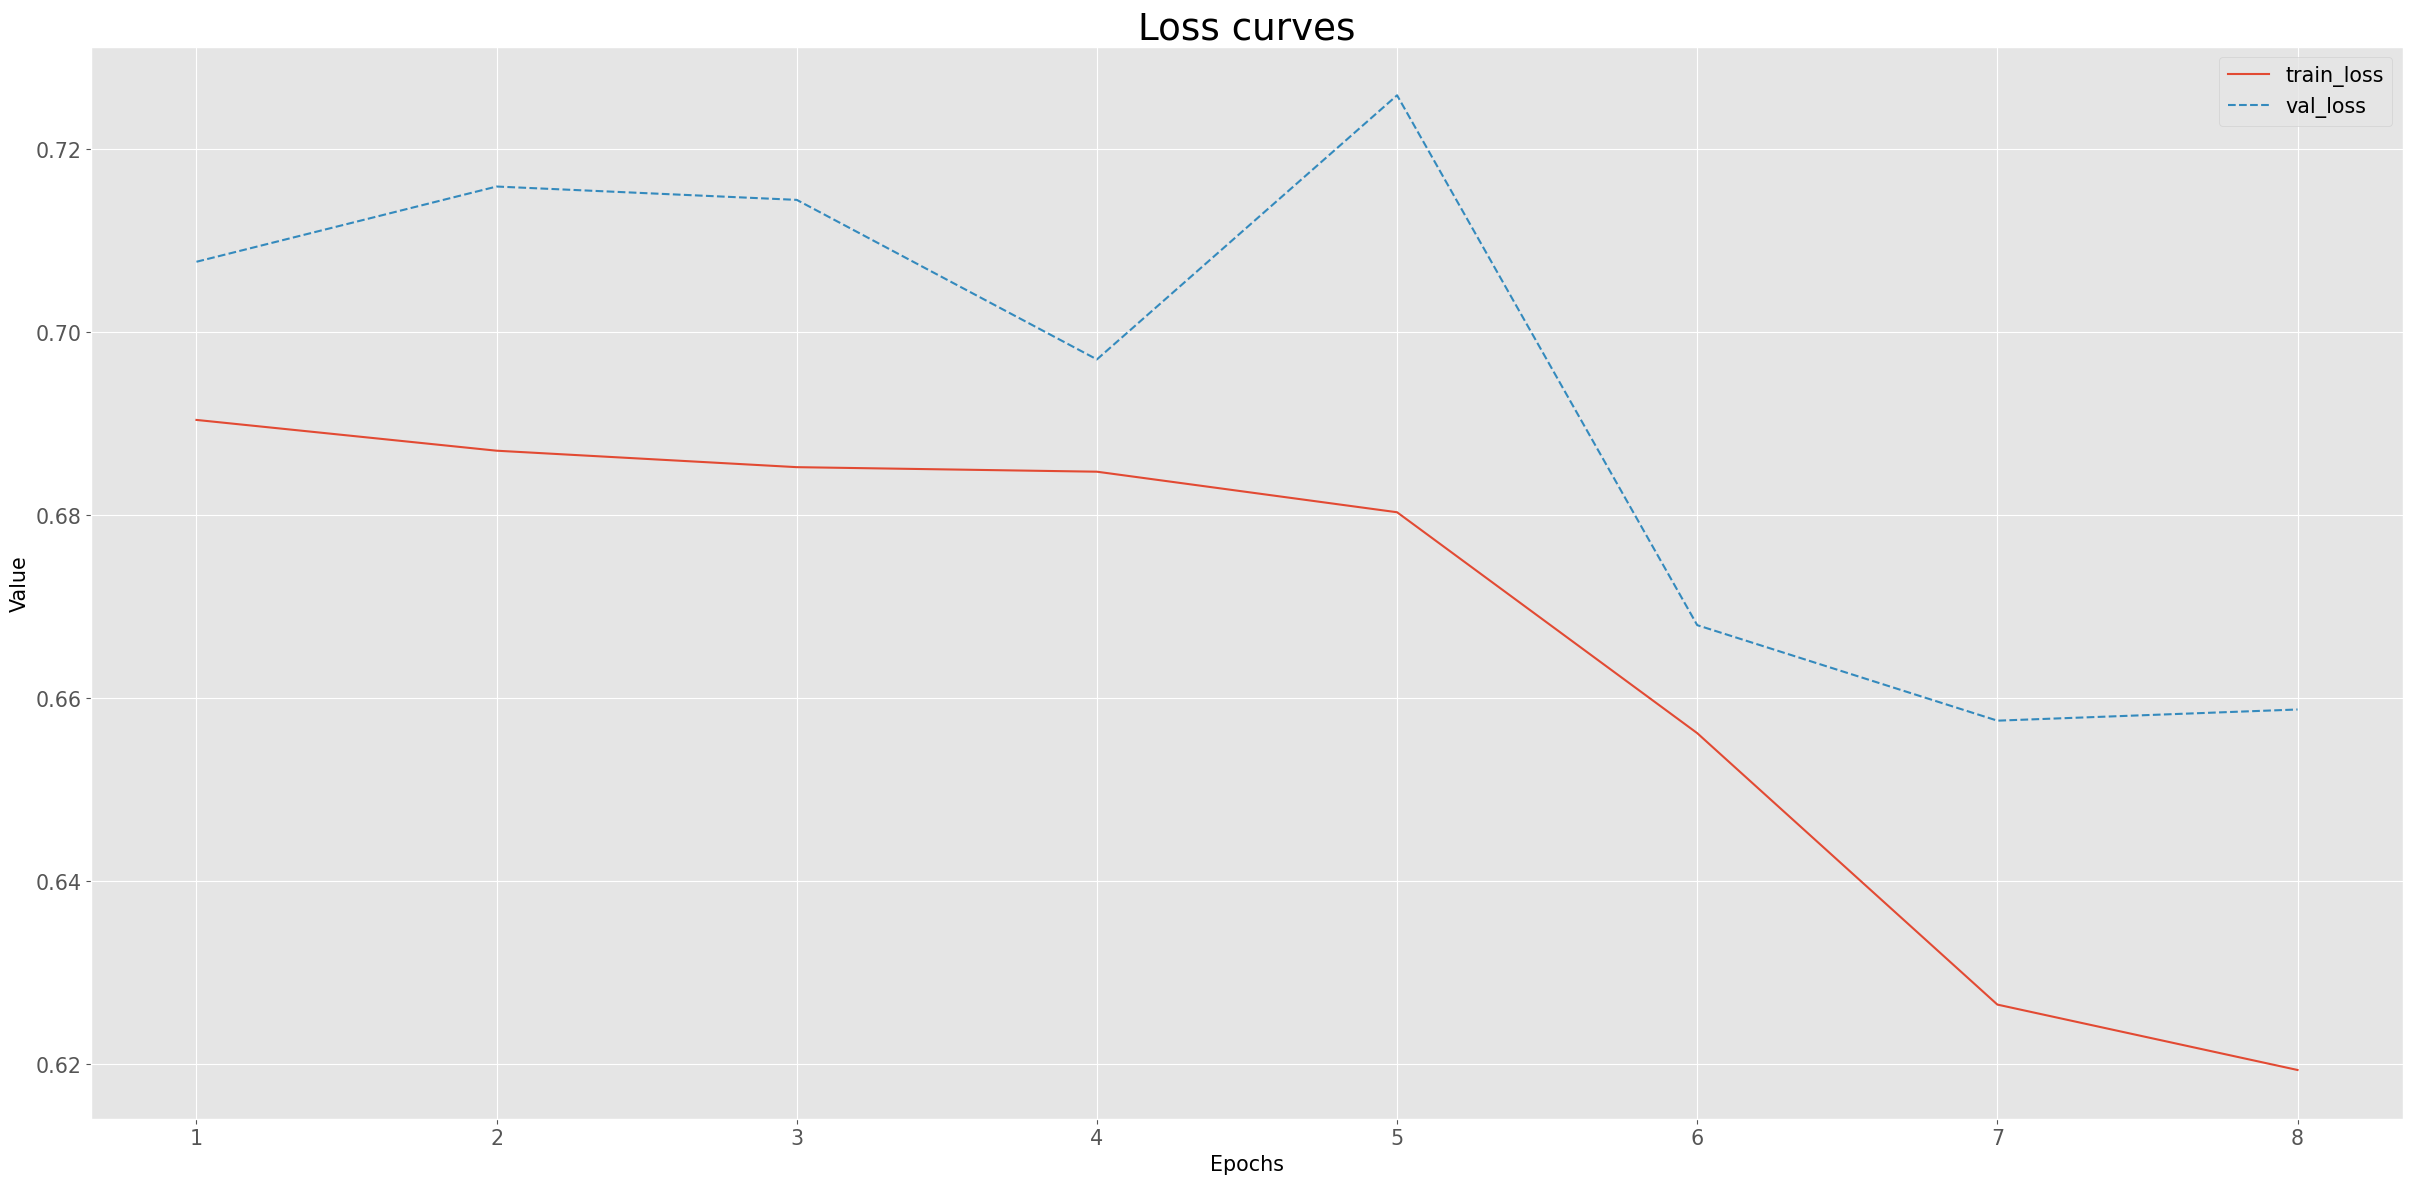

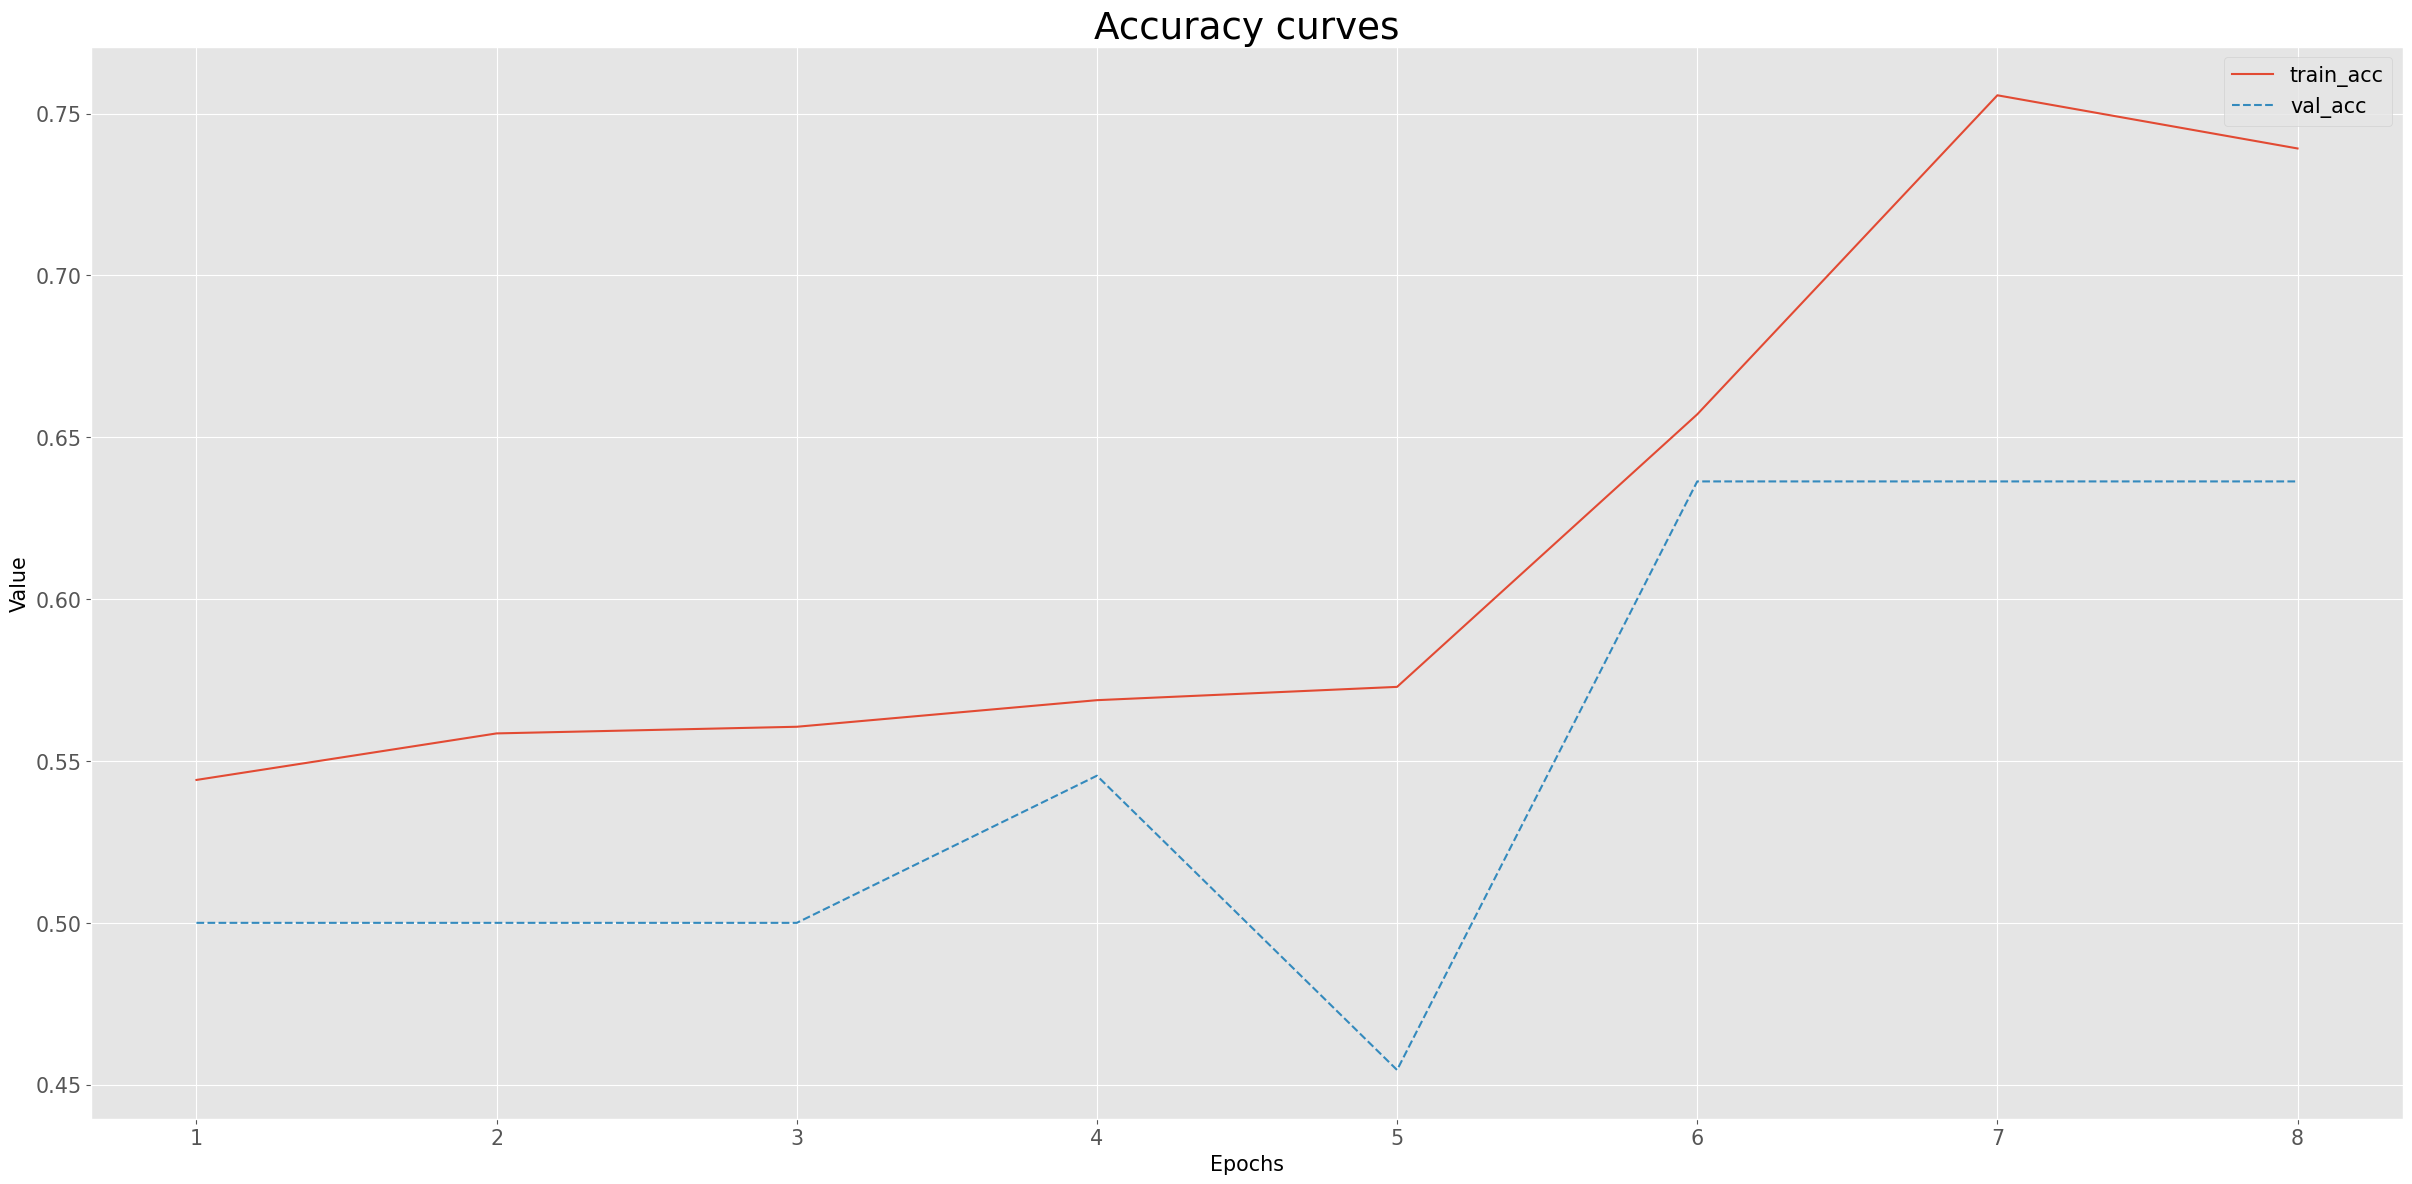

In [59]:
# Plot the loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_title='Loss curves', use_linestyles=['-', '--'], magnify=0.2)

# Plot the accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_title='Accuracy curves', use_linestyles=['-', '--'], magnify=0.2)

## Evaluation on the test dataset



In [60]:
true_labels, predictions_labels, avg_epoch_loss = validation (test_dataloader, device)

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.metrics import macro_averaged_mean_absolute_error

print("Accuracy -> ",accuracy_score(true_labels, predictions_labels))
print("Recall -> ",recall_score(true_labels, predictions_labels,average='macro'))
print("Precision -> ",precision_score(true_labels, predictions_labels,average='macro'))
print("F1 score -> ",f1_score(true_labels, predictions_labels,average='macro'))
# print("MAE -> ",mean_absolute_error(true_labels, predictions_labels))
print("Macro MAE -> ",macro_averaged_mean_absolute_error(true_labels, predictions_labels))
print(confusion_matrix(true_labels, predictions_labels))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?it/s]

Accuracy ->  0.8205128205128205
Recall ->  0.8008021390374331
Precision ->  0.8472222222222222
F1 score ->  0.8078817733990148
Macro MAE ->  0.19919786096256686
[[11  6]
 [ 1 21]]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
